In [7]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor, DistanceMetric
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.metrics import r2_score
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN
from ml_utils import graph
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import collections
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go 

init_notebook_mode(connected=True)

%pylab inline
pylab.rcParams['figure.figsize'] = (15,9)

out_dir = '~/ftb/papi_output/speedup/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['plot']
`%matplotlib` prevents importing * from pylab and numpy



In [3]:
def aggregate(df):
    return df.groupby(['alg','run'])[df.columns[2:]].min()

def remove_outliers(x, y, df):
    xs = RobustScaler().fit_transform(x)
    
    db = DBSCAN(eps=1.9, min_samples=5, metric='chebyshev')
    cluster_labels = db.fit_predict(xs)
    x2 = [xi for cl, xi in zip(cluster_labels, x) if cl != -1]
    y2 = [yi for cl, yi in zip(cluster_labels, y) if cl != -1]
    df = df.drop(df.index[[i for i, cl in enumerate(cluster_labels) if cl == -1]])
    print('\t', len(x)-len(x2), 'outliers removed')
    return np.array(x2), np.array(y2), df

In [18]:
def best_neigh(x, y, df, pca_range, neigh_range):
    best = -inf
    best_n = (None, None)
    best_clf = (None, None)

    for n_comp in pca_range:
        for n_neigh in neigh_range:
            pca = PCA(n_components=n_comp)
            pca.fit(x)
            x2 = pca.transform(x)
            x2_test = x2
            y2_test = y
            #x2, y2, df2 = remove_outliers(x2, y, df)
            y2=y
            
            neigh = KNeighborsRegressor(n_neighbors=n_neigh, weights='distance')
            neigh.fit(x2, y2)
            
            groups = list(df.index.get_level_values(0))
            
            cv=GroupKFold(n_splits=3).split(x2_test, y2_test, groups)
            score = cross_val_score(neigh, x2_test, y2_test, cv=cv).mean()
            print(n_comp, '\t', n_neigh, '\t', round(score, 2))
            
            if score > best:
                best = score
                best_n = (n_comp, n_neigh)
                best_clf = (pca, neigh)
                
    print('--------------')
    print('PCA:\t', best_n[0])
    print('kNN:\t', best_n[1])
    print('Score:\t', best)
    return best_clf, x2

In [15]:
def load_data(files, scaler=None):
    paths = [out_dir + p for p in files]

    dfs_O0 = [pd.read_csv(path + '_O0.csv', error_bad_lines=False) for path in paths]
    df_O0 = pd.concat(dfs_O0)
    df_O0['run'] = df_O0['run'].astype(str)  
    df_O0 = aggregate(df_O0)
    print(df_O0.shape)
    
    dfs_O3 = [pd.read_csv(path + '_O3.csv', error_bad_lines=False) for path in paths]
    df_O3 = pd.concat(dfs_O3)
    df_O3['run'] = df_O3['run'].astype(str)
    df_O3 = df_O3[['alg', 'run', 'time_O3']]
    df_O3 = aggregate(df_O3)
    print(df_O3.shape)
    
    df = df_O0.merge(df_O3, left_index=True, right_index=True)
    df = df.loc[df['time_O3'] > 1]
    
    for col in df.columns:
        if col[:4] == 'PAPI' and col != 'PAPI_TOT_INS':
            df[col] = df[col].astype(float).div(df['PAPI_TOT_INS'], axis=0)
    df['PAPI_TOT_INS'] = 1
    df = df.dropna()  
    
    df['speedup'] = df['time_O0'] / df['time_O3']

    cols = sorted(list(df.columns.values))
    df = df[cols]

    x = df.drop(['time_O0', 'time_O3', 'speedup'],axis=1).as_matrix()
    y = df['speedup'].as_matrix()
    
    if scaler is None:
        scaler = RobustScaler(quantile_range=(10,90))
        #scaler = StandardScaler()
        x = scaler.fit_transform(x)
    else:
        x = scaler.transform(x)

    print(df.shape)
    print(len(x))
    
    return x, y, df, scaler

In [19]:
x, y, df, scaler = load_data(['o1', 'o2', 'o3'])

(7446, 53)
(7441, 1)
(1361, 55)
1361


/usr/lib/python3/dist-packages/ipykernel_launcher.py:31: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/usr/lib/python3/dist-packages/ipykernel_launcher.py:32: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [20]:
(pca, neigh), x2 = best_neigh(x, y, df, range(2, 15, 2), range(6, 20, 5))
clf = neigh

2 	 6 	 -0.21
2 	 11 	 -0.1
2 	 16 	 -0.08
4 	 6 	 -0.0
4 	 11 	 0.05
4 	 16 	 0.13
6 	 6 	 0.22
6 	 11 	 0.26
6 	 16 	 0.28
8 	 6 	 0.09
8 	 11 	 0.19
8 	 16 	 0.26
10 	 6 	 0.23
10 	 11 	 0.31
10 	 16 	 0.33
12 	 6 	 0.39
12 	 11 	 0.43
12 	 16 	 0.42
14 	 6 	 0.32
14 	 11 	 0.36
14 	 16 	 0.36
--------------
PCA:	 12
kNN:	 11
Score:	 0.42973315880764473


In [23]:
pca = PCA(n_components=12)
pca.fit(x)
x2 = pca.transform(x)

x_test = x2
y_test = y
df_test = df

x2, y, df = remove_outliers(x2, y, df)
pca.explained_variance_ratio_.sum()

	 224 outliers removed


0.9998736502043687

In [24]:
neigh = KNeighborsRegressor(n_neighbors=11, weights='distance')
neigh.fit(x2, y) 
clf = neigh

In [134]:
regr = RandomForestRegressor()
regr.fit(x2, y)
for col, imp in zip(df.columns, regr.feature_importances_):
    print(col, '\t', round(imp * 100, 2), '%')
clf = regr

PAPI_BR_CN 	 47.58 %
PAPI_BR_INS 	 52.42 %


In [9]:
model_path = '../lore/models/'
joblib.dump(scaler, model_path + 'scaler.pkl') 
joblib.dump(pca, model_path + 'pca.pkl')
joblib.dump(neigh, model_path + 'neigh.pkl') 

['../lore/models/neigh.pkl']

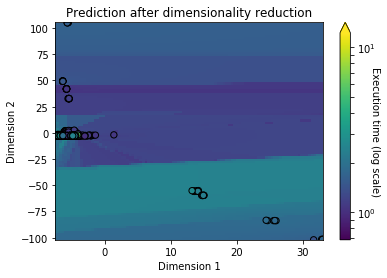

In [9]:
groups = list(df.index.get_level_values(0))
labels = [q.split('_')[-2][-2:] + q.split('_')[-1] for q in groups]
graph(clf, x2, y)
#graph(clf, x2, y, xlim=(-7.7,-4),ylim=(-3,-1), labels=labels)

In [10]:
labels = [q.split('_')[-1] for q in groups]

trace1 = go.Scatter(x=x2[:,0], y=x2[:,1], mode='markers', text=labels, hoverinfo='text',
                        marker = dict(size=8, color=[np.log(q) for q in y], line=dict(width=1, color='rgb(0, 0, 0)')))

layout = go.Layout(showlegend=False, hovermode='closest',
               yaxis=dict(zeroline=False, title='Predicted'),
               xaxis=dict(zeroline=False, title='Measured'))

fig = go.Figure(data = [trace1], layout = layout)
iplot(fig, filename="c-v-predict")

In [25]:
groups = list(df_test.index.get_level_values(0))

cv=GroupKFold(n_splits=3).split(x_test, y_test, groups)
cvres = list(cv)
group_names = [groups[q[1][0]] for q in cvres]

scores = cross_val_score(clf, x_test, y_test, cv=cvres)

scores.mean()

0.4297333496090287

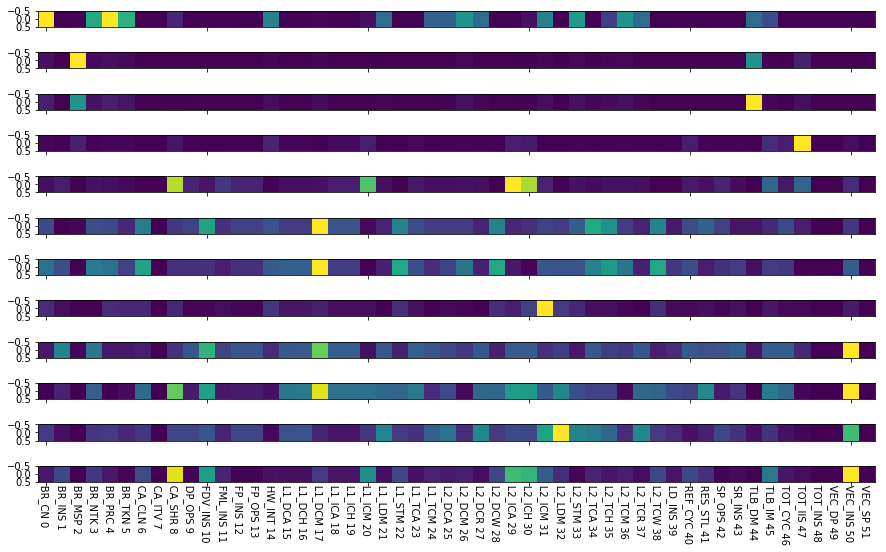

[45, 0, 0, 27, 45, 29, 0, 0, 4, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 1, 15, 0, 0, 13, 14, 23, 15, 0, 0, -1, 20, 0, 25, 0, -8, 23, 15, 0, 0, 0, 0, 0, 0, 16, 10, 0, 0, 0, 0, 0, 0]
[3, 0, 88, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, -45, 0, 0, 7, 0, 0, 0, 0]
[-7, 0, 45, -4, -7, -4, 0, 0, 0, 0, 0, 0, 0, 0, -3, 0, 0, 2, 0, 0, 0, -1, 0, 0, 0, 0, -3, -1, 0, 0, 0, -3, 0, -3, 1, 2, -3, -1, 0, 0, 0, 0, 0, 0, 87, -1, 0, 3, 0, 0, 0, 0]
[-1, 0, -8, 0, -1, -1, 0, 0, 5, 0, 0, 0, 0, 0, 9, 1, 1, 0, 2, 2, 7, 0, 0, 2, 0, 0, 0, 0, 0, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 1, 0, 0, 0, 11, 7, 96, 0, 0, 3, 0]
[-2, 4, 0, 2, -2, -1, 0, 0, 47, 5, 2, 8, 5, 5, 0, 1, 1, 2, 4, 4, 39, -2, 0, 3, -1, -1, -2, -2, 0, 53, 47, 5, 0, -2, 1, 2, -2, -2, 0, 0, 3, 2, 5, 1, 0, 17, 3, -17, 0, 0, 6, 0]
[-11, 0, 0, -11, -11, -5, 21, 0, -7, 9, 29, 6, 9, 9, 12, 8, 8, 49, 12, 12, 1, 4, 22, 11, 8, 8, 8, 4, 22, -5, -6, 9, -8, 14, 30, 25, 8, 4, 22, 3, 11, 15, 

In [26]:
# just to visualize which of 52 PAPI output events are most significant (marked in yellow)

lab = df.columns[:52]

fig, axs = plt.subplots(nrows=pca.n_components)
for i, ax in enumerate(axs): 
    if i == pca.n_components - 1:
        for j, txt in enumerate(lab):
            ax.annotate('      '+txt[5:]+' '+str(j), (j-.5, 0), rotation=270)
    pcas = [abs(q) for q in pca.components_[i:i+1]]
    ax.imshow(pcas)
    ax.set_xticklabels([])
plt.show()

for comp in pca.components_:
    print([int(q * 100) for q in comp])

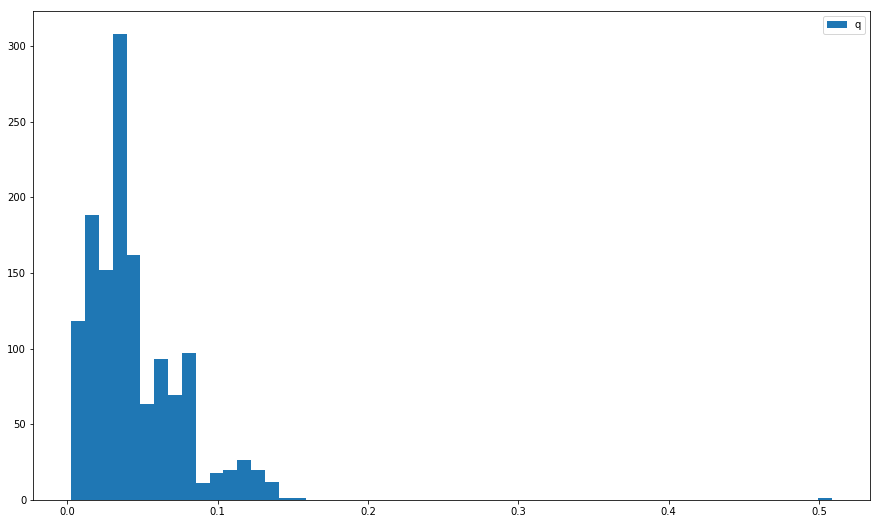

In [125]:
s = [[q] for q in df['PAPI_BR_CN']]
ss = StandardScaler().fit_transform(s).flatten()
sr = RobustScaler().fit_transform(s).flatten()
plt.hist(np.array(s).flatten(), bins=55, label='q')
#plt.hist(ss, bins=55, label='s')
#plt.hist(sr, bins=55, label='r')
plt.legend()